In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from lib.utils import forward_casey,forward_casey_corrected,run_new_state_machine_on_thresholded_predictions

def read_raw_delta(dir):
    df = pd.read_csv(dir,skiprows=1).drop('activity',axis=1)
    return df
def get_windowed_from_raw(raw_dataframe):
    X = torch.from_numpy(raw_dataframe[['acc_x','acc_y','acc_z']].to_numpy())
    x = X[:,0].unsqueeze(1)
    y = X[:,1].unsqueeze(1)
    z = X[:,2].unsqueeze(1)
    xs = [x[:-99]]
    ys = [y[:-99]]
    zs = [z[:-99]]
    for i in range(1,99):
        xs.append(x[i:i-99])
        ys.append(y[i:i-99])
        zs.append(z[i:i-99])
    xs.append(x[99:])
    ys.append(y[99:])
    zs.append(z[99:])
    xs = torch.cat(xs,axis=1).float()
    ys = torch.cat(ys,axis=1).float()
    zs = torch.cat(zs,axis=1).float()
    X = torch.cat([xs,ys,zs],axis=1)
    return X

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = read_raw_delta(f'./2022-09-20_21_08_58/raw/2022-09-20_21_08_58.0.csv')
X = get_windowed_from_raw(df)
fig = px.line(df,y=['acc_x','acc_y','acc_z'])
fig.show(renderer='browser')

3.896097263


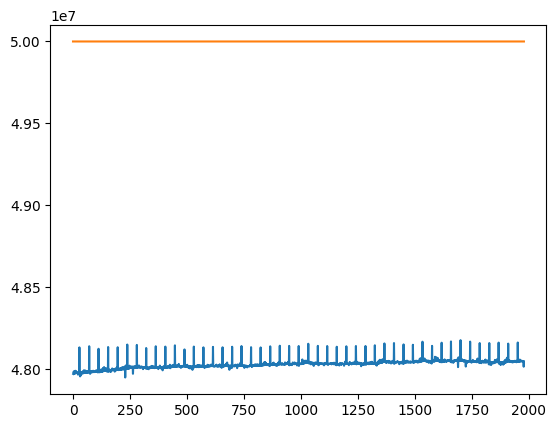

In [13]:
(df.timestamp[len(df)-1]-df.timestamp[0])/1e9
len(df)/20
df.timestamp.diff().plot()
plt.plot(np.ones(len(df))*5e7)
print(((5e7*(len(df)-1))-df.timestamp.diff().sum())/1e9)

In [14]:
labels_recomputed = forward_casey(X)
df['raw_recomputed'] = labels_recomputed
labels_recomputed = [1 if y > .85 else 0 for y in labels_recomputed]
df['label_recomputed'] = labels_recomputed

labels_recomputed_corrected = forward_casey_corrected(X)
df['raw_recomputed_corrected'] = labels_recomputed_corrected
labels_recomputed_corrected = [1 if y > .85 else 0 for y in labels_recomputed_corrected]
df['label_recomputed_corrected'] = labels_recomputed_corrected

states,puff_locations = run_new_state_machine_on_thresholded_predictions(labels_recomputed)
states_corrected,puff_locations_corrected = run_new_state_machine_on_thresholded_predictions(labels_recomputed_corrected)

100%|██████████| 1880/1880 [00:00<00:00, 11453.07it/s]


In [20]:
df['rawlabel_10'] = df['rawlabel']*10
df['raw_recomputed_10'] = df['raw_recomputed']*10
df['label_recomputed_10'] = df['label_recomputed']*10
df['label_recomputed_corrected_10'] = df['label_recomputed_corrected']*10
df['label_10'] = df['label']*10
df['raw_recomputed_corrected_10'] = df['raw_recomputed_corrected']*10
df['state_recomputed'] = states
df['state_recomputed_corrected'] = states_corrected
fig = px.line(df,y=['state','state_recomputed_corrected'])
fig.show(renderer='browser')